In [3]:
import muspy
import numpy as np
import pypianoroll as pypir
from file_list import file_list

PATH_PREFIX = 'data_set/'

In [4]:
path_prefix = 'data_set/'
duration_dict = {}

for file_name in file_list:
    midi = muspy.read_midi(f'{path_prefix}{file_name}')
    
    song_title = file_name.split('.')[0]
    
    bpm_str = song_title.split('-')[3]
    bpm = float(bpm_str)
    
    tempo_cleaned = midi.deepcopy()
    tempo_cleaned.tempos = [muspy.Tempo(0, bpm)]
    
    res = tempo_cleaned.resolution
    
    print(song_title)
    
    left_dur_list = []
    
    for note in tempo_cleaned.tracks[0]:
        dur = note.duration / (res) # note length in 64th notes
        
        note_lengths = [1, 0.5, 0.25, 0.125, 0.0625]
        note_length_list = []
        
        left_dur = dur
        
        for length in note_lengths:
            note_length = left_dur // length
            left_dur = left_dur - (note_length * length)
            note_length_list.append(note_length)
            
        if left_dur > 0:
            note_length_list.append(left_dur)
            left_dur_list.append(left_dur)
            
        print(note_length_list)
    
    print()
    print()
        

blues_breaker-4|4-Am-120-2-001-c
[0.0, 0.0, 1.0, 0.0, 0.0, 0.020833333333333315]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.016666666666666663]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.016666666666666663]
[0.0, 1.0, 0.0, 1.0, 0.0, 0.012499999999999956]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.020833333333333315]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.04999999999999999]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.04999999999999999]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.020833333333333315]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.020833333333333315]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.03333333333333344]


blues_breaker-4|4-Am-120-2-001-r
[0.0, 1.0, 0.0, 1.0, 0.0, 0.04166666666666663]
[0.0, 1.0, 0.0, 1.0, 0.0, 0.04166666666666663]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.037500000000000006]
[0.0, 0.0, 0.0, 0.0, 1.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.020833333333333315]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.04999999999999999]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.04999999999999999]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.03750000000000009]


blues_breaker-4|4-Am-120-2-002-c
[0.0, 0.0, 1.0, 0.0, 0.0, 0.016666666666666663]
[0.0, 0.0, 1.0,

blues_breaker-4|4-Am-120-2-003-r


[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

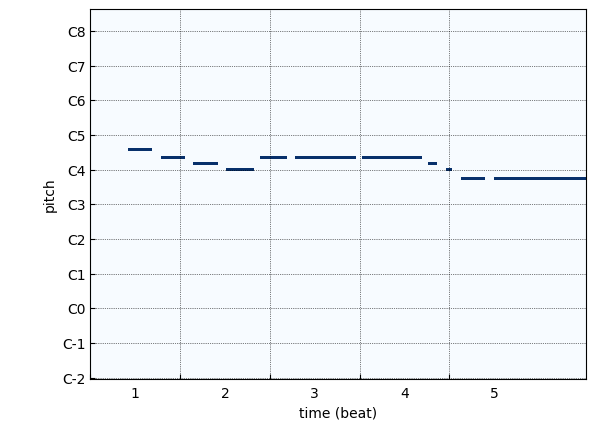

In [5]:
filenames = file_list[5:7]

midis = [muspy.read(f'{PATH_PREFIX}{filename}') for filename in filenames]

song_titles = [filename.split('.')[0] for filename in filenames]

bpms = [float(song_title.split('-')[3]) for song_title in song_titles]

tempo_cleaneds = [midi.deepcopy() for midi in midis]
new_tempos = [muspy.Tempo(0, bpm) for bpm in bpms]

for idx, song in enumerate(tempo_cleaneds):
    song.tempos = [new_tempos[idx]]    

pianorolls = [muspy.to_pypianoroll(tempo_cleaned) for tempo_cleaned in tempo_cleaneds]

print(song_titles[0])
pianorolls[0].plot()

In [6]:
res_pianoroll_obj = pianorolls[0]
res_pianoroll = res_pianoroll_obj.tracks[0].pianoroll

def pianoroll2binaryroll(pianoroll):
    new_pianoroll = []

    for timeframe in pianoroll:
        new_timeframe = []
        
        for velocity in timeframe:
            if velocity > 0 :
                new_timeframe.append(1)
            else:
                new_timeframe.append(0)   
                
        new_pianoroll.append(new_timeframe)
    
    return new_pianoroll

In [7]:
def binaryroll2pitchlist(binaryroll): # also remove note overwrapping
    pitch_list = []

    for timeframe in binaryroll:
        prev_pitch = 0
        
        sum_timeframe = sum(timeframe)
        
        if sum(timeframe) == 0:
            pitch_list.append(0)
            continue
        
        for pitch, is_on in enumerate(timeframe):
            if sum_timeframe == 1 and is_on == 1:
                pitch_list.append(pitch + 1)
                prev_pitch = pitch + 1
                break
            
            if sum_timeframe > 1 and is_on == 1 and pitch + 1 != prev_pitch:
                pitch_list.append(pitch + 1)
                prev_pitch = pitch + 1
                break
    
    return pitch_list

In [8]:
def pitchlist2pianoroll(pitch_list):
    new_pianoroll = []

    for pitch in pitch_list:
        new_timeframe = [0 for i in range(128)]
        if pitch > 0:
            new_timeframe[pitch - 1] = 127
        new_pianoroll.append(new_timeframe)
    
    return np.array(new_pianoroll)

In [24]:
# UNIT_AS_TICK = 120 # 16th note as tick
# BEAT_AS_TICK = 4 * UNIT_AS_TICK # 4th note as tick

UNIT_AS_TICK = 60 # 32th note as tick
BEAT_AS_TICK = 8 * UNIT_AS_TICK # 4th note as tick

BAR_AS_TICK = 4 * BEAT_AS_TICK

def add_padding_bar(pitch_list):
    ticks_in_pianoroll = len(pitch_list)

    num_bars_in_pianoroll = ticks_in_pianoroll // BAR_AS_TICK
    left_over_ticks_in_pianoroll = ticks_in_pianoroll % BAR_AS_TICK

    num_ticks_to_add = BAR_AS_TICK - left_over_ticks_in_pianoroll

    ticks_to_add_array = np.array([0 for _ in range(num_ticks_to_add)])

    pitch_list = np.concatenate((pitch_list, ticks_to_add_array), axis=0)
    
    return pitch_list
    

In [25]:
quantized_pianoroll_obj = pianorolls[0].copy()
before_quantized_pianoroll = quantized_pianoroll_obj.tracks[0].pianoroll
before_quantized_pianoroll_binaryroll = pianoroll2binaryroll(before_quantized_pianoroll)
before_quantized_pianoroll_pitch_list = binaryroll2pitchlist(before_quantized_pianoroll_binaryroll)
# before_quantized_pianoroll_pitch_list = add_padding_bar(before_quantized_pianoroll_pitch_list)

In [26]:
from collections import Counter

len_pitch_list = len(before_quantized_pianoroll_pitch_list)

short_quantized_pianoroll_pitch_list = []

for i in range(0, len_pitch_list, UNIT_AS_TICK):
    sliced = before_quantized_pianoroll_pitch_list[i : i + UNIT_AS_TICK]

    pitch_cnt_dict = dict(Counter(sliced))
    
    max_pitch_cnt_value = max(pitch_cnt_dict.values())
    max_pitch_cnt_pitch = [key for key, val in pitch_cnt_dict.items() if val == max_pitch_cnt_value][0]
    
    short_quantized_pianoroll_pitch_list.append(max_pitch_cnt_pitch)
    

quantized_pianoroll_pitch_list = []

for pitch in short_quantized_pianoroll_pitch_list:
    for _ in range(UNIT_AS_TICK):
        quantized_pianoroll_pitch_list.append(pitch)

    

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

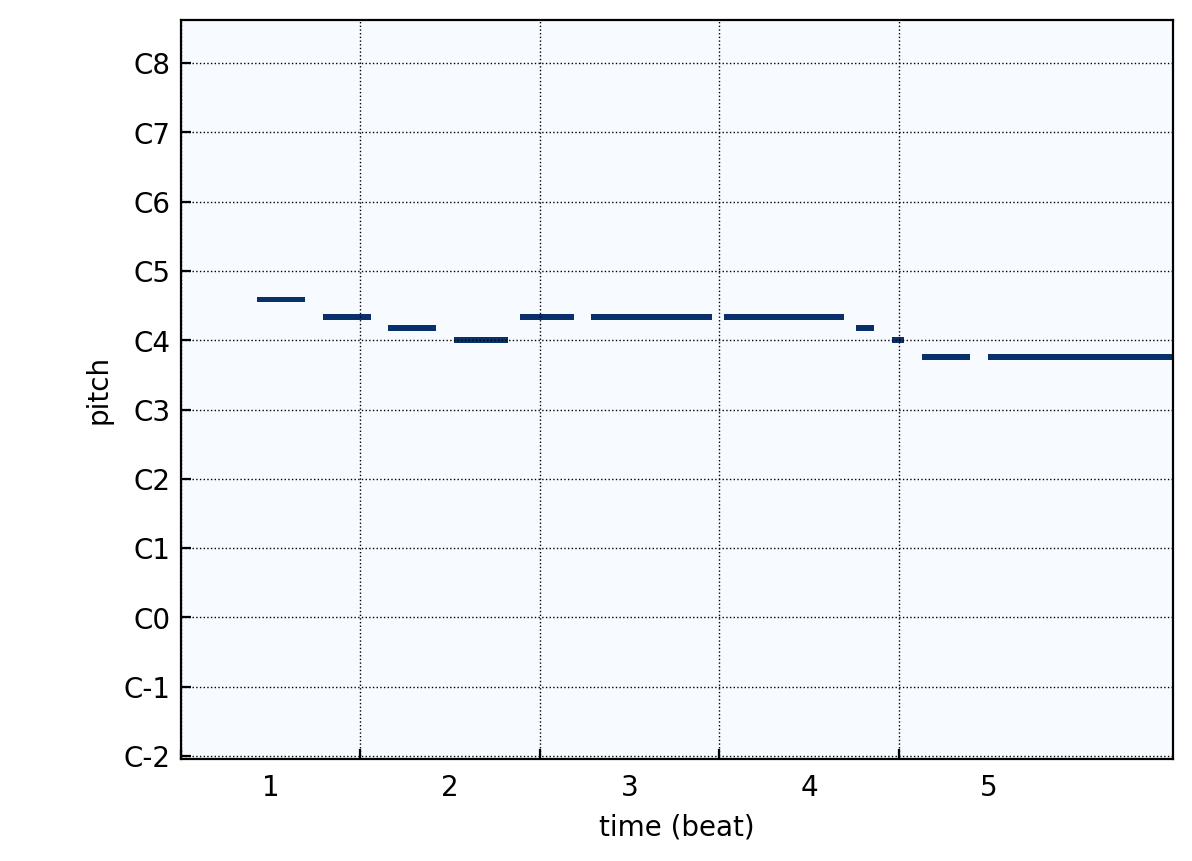

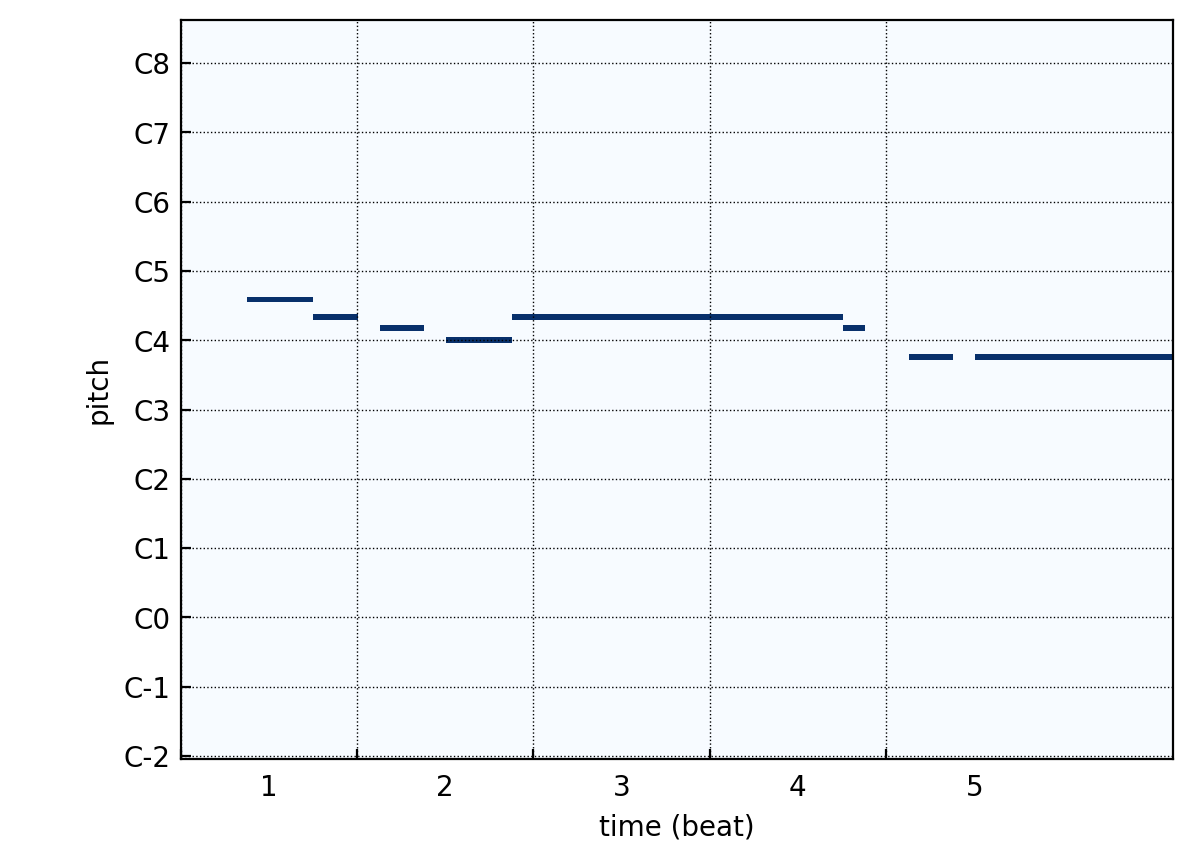

In [27]:
import IPython.display as ipd

quantized_pianoroll_obj.tracks[0].pianoroll = pitchlist2pianoroll(quantized_pianoroll_pitch_list)

ipd.display(res_pianoroll_obj.plot())
ipd.display(quantized_pianoroll_obj.plot())